First we will read through all the documents in the data folder and store them in text field in a dataframe along with the right label

In [ ]:
import docx2txt
import PyPDF2 
import pptx
from pptx import Presentation
import os
import glob
import pandas as pd
import numpy as np
from xlrd import open_workbook
import re

doc_label=[] 
doc_text=[]
DocPath=[]
DocType=[]
# Other items to be removed - dates, Numbers, Hyperlinks, what about images?, Should we keep headers
Dictionary={"\n":" ","\xa0":" ", "NULL":" ", "NOT NULL": "  ","\u200b" :" "}

os.chdir('C://Users//L833377//Desktop//ClassificationEngineIdeas//data')
rootdir = os.getcwd()

for subdir, dirs, files in os.walk(rootdir):

    for file in files:
        #print(os.path.join(subdir, file))
        filepath = subdir + os.sep + file

        if filepath.endswith(".docx"):
            # read in word file
            print(filepath)
            result = docx2txt.process(filepath)
            
            for i in Dictionary:
                result=result.replace(i,Dictionary[i])
            doc_text.append(result)
            #doc_label.append(label[j-1])
            doc_label.append(re.split(r'\\+',filepath)[6])
            DocPath.append(file)
            DocType.append('Word')
            
        # importing required modules 

        elif filepath.endswith(".pdf"):
            # Note that Epic documentation pdf files could not be read. It depends on how the pdf files was generated
            # creating a pdf file object 
            #print(filepath)
            pdfFileObj = open(filepath, 'rb') 
  
            # creating a pdf reader object 
            pdfReader = PyPDF2.PdfFileReader(pdfFileObj,strict=False) 
  
            # printing number of pages in pdf file 
            #print(pdfReader.numPages) 
  
            # creating a page object 
            pageObj = pdfReader.getPage(0) 
  
            # extracting text from page 
            result=pageObj.extractText()
            
        
            #print(result)
            # closing the pdf file object 
            pdfFileObj.close() 
        
            for i in Dictionary:
                result=result.replace(i,Dictionary[i])
                
            doc_text.append(result)
            #Attach the label
            doc_label.append(re.split(r'\\+',filepath)[6])
            DocPath.append(file)
            DocType.append('pdf')
        elif filepath.endswith(".pptx"):        

            # Check the file being processed
            #print(file)
            pptx_txt=str()
            prs = Presentation(filepath)

            for slide in prs.slides:
                for shape in slide.shapes:
                    #print(shape)
                    if hasattr(shape, "text"):
                        pptx_txt += shape.text + " "
                    # For pptx.shapes.graphfrm.GraphicFrame object text could be inside the table object
                    #A graphic frame placeholder can contain a table, a chart, or SmartArt                    
                    elif shape.has_table:
                        table = shape.table
                        for r in table.rows:
                            
                            for c in r.cells:
                                pptx_txt += c.text_frame.text + " "
            for i in Dictionary:
                pptx_txt=pptx_txt.replace(i,Dictionary[i])
            doc_text.append(pptx_txt)
            #doc_label.append(label[j-1])
            doc_label.append(re.split(r'\\+',filepath)[6])
            DocPath.append(file)
            DocType.append('powerpoint')  
            
        elif filepath.endswith(".xlsx") or filepath.endswith(".xls"):                            
            wb = open_workbook(filepath,"rb")
            xlsx_txt=str()
            for s in wb.sheets():
                #print('Sheet:',s.name)
                
                for row in range(s.nrows):

                    for col in range(s.ncols):
                        value  = (s.cell(row,col).value)
                        try : value = str(int(value))
                        except : pass
                        xlsx_txt+= value + ' '

            for i in Dictionary:
                xlsx_txt=xlsx_txt.replace(i,Dictionary[i])           
            doc_text.append(xlsx_txt)
            #doc_label.append(label[j-1])
            doc_label.append(re.split(r'\\+',filepath)[6])
            DocPath.append(file)
            DocType.append('Excel')           
            
        else:
            pass
                        
df1 = {
    'Label':doc_label,
   'Text':doc_text,
    'DocName':DocPath,
    'DocType':DocType}
 
df1 = pd.DataFrame(df1,columns=['Label','Text','DocName','DocType'])

# overwriting column with replaced value of age  
#df1["Text"]= df1["Text"].str.replace(",", " ", case = False).str.replace("\n", " ", case = False).str.replace("\t"," ",case=False).str.replace(r"\\","",case=False).str.replace("Â","").str.replace("﴿","").str.replace("﴾","").str.lower()

df1.to_csv("KP_Corpus.csv",index=False)
#df1.to_excel("KP_Corpus.xlsx",sheet_name='Extracted_Text')  


In [ ]:
df1.head()

Pre-process data

In [3]:
import re, string 
import pandas as pd   
from collections import defaultdict
import spacy
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'[\w\.-]+@([\w\.-]+)','',text) # remove email addresses from text
    # Remove a sentence if it is only one word long
    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)
df1['cleanText'] = pd.DataFrame(df1.Text.apply(lambda x: clean_text(x)))
df1['Length']=df1['cleanText'].str.len()
# df1['length'] = df1['text'].apply(len)

Check for Nulls

In [4]:
df1.isnull().sum()

Label        0
Text         0
DocName      0
DocType      0
cleanText    5
Length       5
dtype: int64

In [5]:
# remove the entries which were not read correctly
df1=df1[df1['cleanText'].isnull()==False]

Analysis

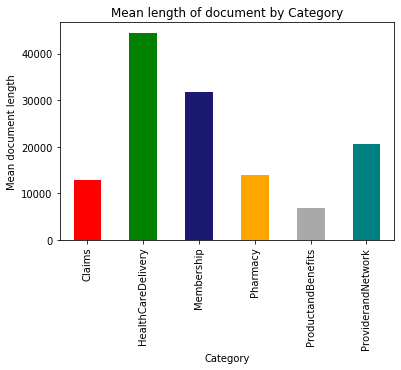

In [6]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
#define a dictionary that maps the Category values to colours, and use the Pandas “replace” function to insert these into the plotting command. 
#colours = {"Claims": "#273c75", "HealthCareDelivery": "#bd32bb","Membership": "#bd5732", "Pharmacy": "#44bd32","ProductandBenefits": "#bd9a32", "ProviderandNetwork": "#bd3250"}
# issue it is only taking the first color in the mapping and aplying to all
#colours = {"Claims": "teal", "HealthCareDelivery": "green","Membership": "blue", "Pharmacy": "yellow","ProductandBenefits": "black", "ProviderandNetwork": "red"}
#df1.groupby("Label")['Length'].mean().plot(kind='bar', title="Mean length of document by Category",color=df1['Label'].replace(colours))

colours = ['red', 'green', 'midnightblue', 'orange', 'darkgrey','teal']
df1.groupby("Label")['Length'].mean().plot(kind='bar', title="Mean length of document by Category",color=colours)

#could also use barh
#plt.xticks(rotation=10, horizontalalignment="left")
#plot.title("Mean length of document by Category")
plt.xlabel("Category")
plt.ylabel("Mean document length")
plt.show()

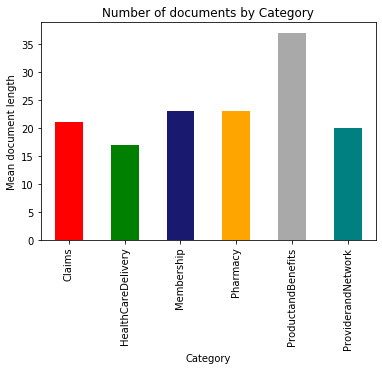

In [7]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
#define a dictionary that maps the Category values to colours, and use the Pandas “replace” function to insert these into the plotting command. 
#colours = {"Claims": "#273c75", "HealthCareDelivery": "#bd32bb","Membership": "#bd5732", "Pharmacy": "#44bd32","ProductandBenefits": "#bd9a32", "ProviderandNetwork": "#bd3250"}
# issue it is only taking the first color in the mapping and aplying to all
#colours = {"Claims": "teal", "HealthCareDelivery": "green","Membership": "blue", "Pharmacy": "yellow","ProductandBenefits": "black", "ProviderandNetwork": "red"}
#df1.groupby("Label")['Length'].mean().plot(kind='bar', title="Mean length of document by Category",color=df1['Label'].replace(colours))

colours = ['red', 'green', 'midnightblue', 'orange', 'darkgrey','teal']
df1.groupby("Label")['DocType'].count().plot(kind='bar', title="Number of documents by Category",color=colours)

#could also use barh
#plt.xticks(rotation=10, horizontalalignment="left")
#plot.title("Mean length of document by Category")
plt.xlabel("Category")
plt.ylabel("Mean document length")
plt.show()

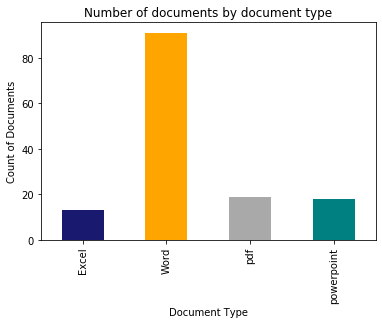

In [8]:
colours = ['midnightblue','orange', 'darkgrey','teal']
df1.groupby("DocType")['DocName'].count().plot(kind='bar', title="Number of documents by document type",color=colours)

#could also use barh
#plt.xticks(rotation=10, horizontalalignment="left")
#plot.title("Mean length of document by Category")
plt.xlabel("Document Type")
plt.ylabel("Count of Documents")
plt.show()

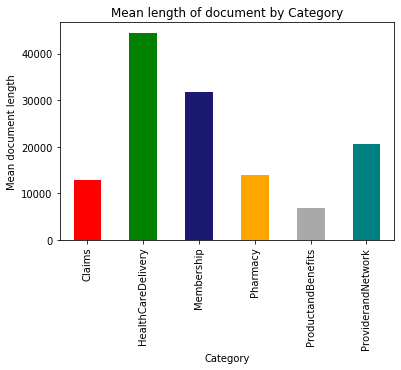

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.colors as colors

colors = ['red', 'green', 'midnightblue', 'orange', 'darkgrey','teal']
df1.groupby("Label")['Length'].mean().plot(kind='bar', title="Mean length of document by Category",color=colors)

plt.xlabel("Category")
plt.ylabel("Mean document length")
plt.show()

Look at the outlier in document length

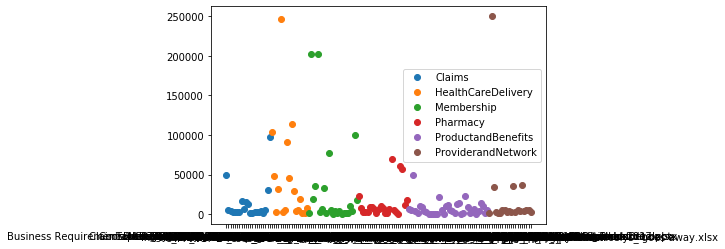

In [10]:
groups = df1.groupby("Label")
for name, group in groups:
    plt.plot(group["DocName"], group["Length"], marker="o", linestyle="", label=name)
plt.legend()

In [11]:
# We will eliminiate the top 3 
df2= df1[df1['cleanText'].str.len()<300000]

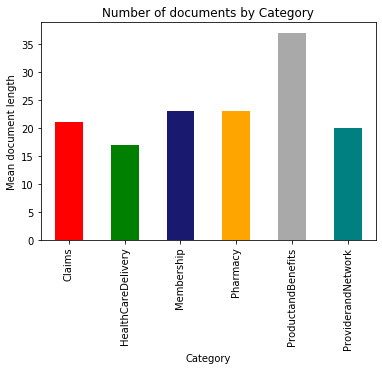

In [12]:
colours = ['red', 'green', 'midnightblue', 'orange', 'darkgrey','teal']
df1.groupby("Label")['DocType'].count().plot(kind='bar', title="Number of documents by Category",color=colours)

plt.xlabel("Category")
plt.ylabel("Mean document length")
plt.show()

Look for documents for which no text was extracted and resolve as needed

In [13]:
df1['category_id']=df1['Label'].factorize()[0]
#use the .sample method of your dataframe to sample all rows without replacement:
# The frac keyword argument specifies the fraction of rows to return in the random sample, so frac=1 means return all rows (in random order).
# to shuffle your dataframe in-place and reset the index, you could do e.g. df = df.sample(frac=1).reset_index(drop=True)
df1['category_id'].sample(frac=1)[0:10]

102    4
84     3
26     1
93     4
2      0
37     1
8      0
16     0
25     1
126    5
Name: category_id, dtype: int64

In [14]:
# Create a new pandas dataframe "category_id_df", which only has unique Labels, also sorting this list in order of category_id values
 
category_id_df = df1[['Label', 'category_id']].drop_duplicates().sort_values('category_id')
# Create a dictionary ( python datastructure - like a lookup table) that 
# can easily convert category names into category_ids and vice-versa
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Label']].values)

Important arguments to be tuned with the TfIdfRetriever:

max_df is the max fraction of documents where each specific token appears in order to have that token selected in the tf-idf matrix. If you have max_df set to a number that multiplied by number of documents is lower than min_df no token will be selected by the TfidfVectorizer for the construction of the matrix. 

default 1


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10000,sublinear_tf=True, min_df=6,norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df1.cleanText).toarray() # Remaps the words in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents

labels = df1.category_id    

In [17]:
import numpy as np

from sklearn.manifold import TSNE

# We will use the entire dataset as it is small 
# Sampling a subset of our dataset because t-SNE is computationally expensive

SAMPLE_SIZE = int(len(features))

np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)         
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features 

Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike [series.py:942]


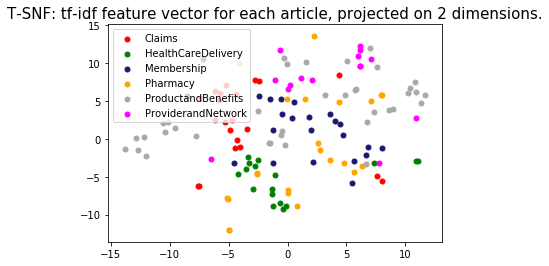

In [18]:

import matplotlib.pyplot as plt

colors = ['red', 'green', 'midnightblue', 'orange', 'darkgrey','magenta']

# Find points belonging to each category and plot them
# s is the size of each point
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=25, c=colors[category_id], label=category)

plt.title("T-SNF: tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
#plt.figure(figsize=(1,1))

plt.legend(loc='best',edgecolor=None,frameon=None)

#legend(bbox_to_anchor=(1,0), loc="lower right",  bbox_transform=fig.transFigure)

#plt.plot()

Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike [series.py:942]


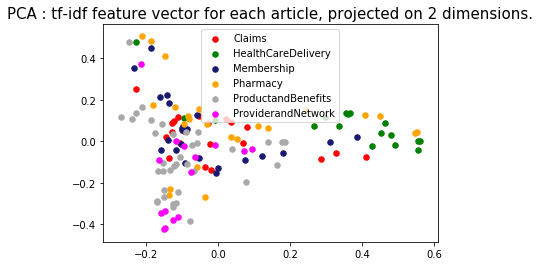

In [19]:
from sklearn.decomposition import PCA

projected_features = PCA(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features of 30% of Randomly chosen samples
colors = ['red', 'green', 'midnightblue', 'orange', 'darkgrey','magenta']

# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("PCA : tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

In [20]:
# Reference for Word2Vec with Classification Model:https://github.com/susanli2016/NLP-with-Python

View wordclouds



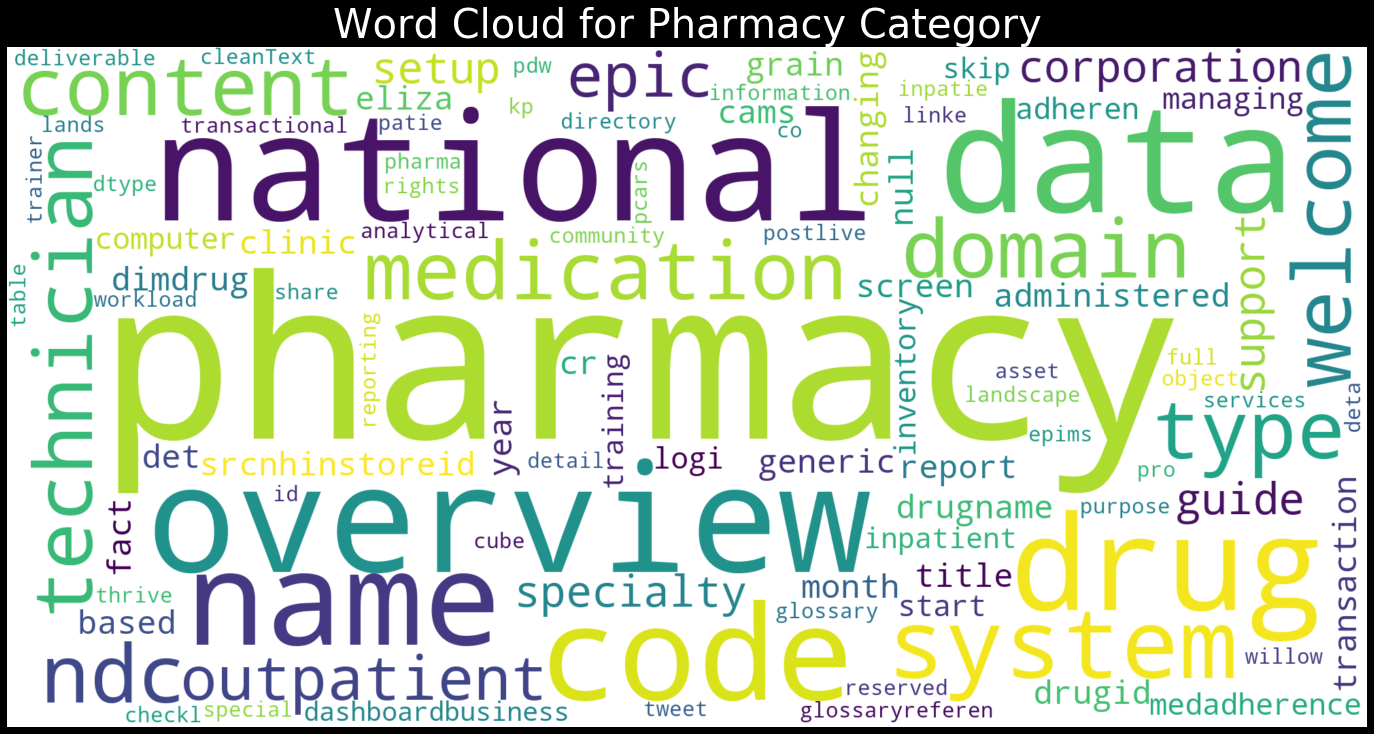

In [21]:
from wordcloud import WordCloud
#import matplotlib.pyplot as plt
text = df1[df1['Label']=='Pharmacy']['cleanText']
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'white').generate(str(text))
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Word Cloud for Pharmacy Category',fontsize=40,color="white")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

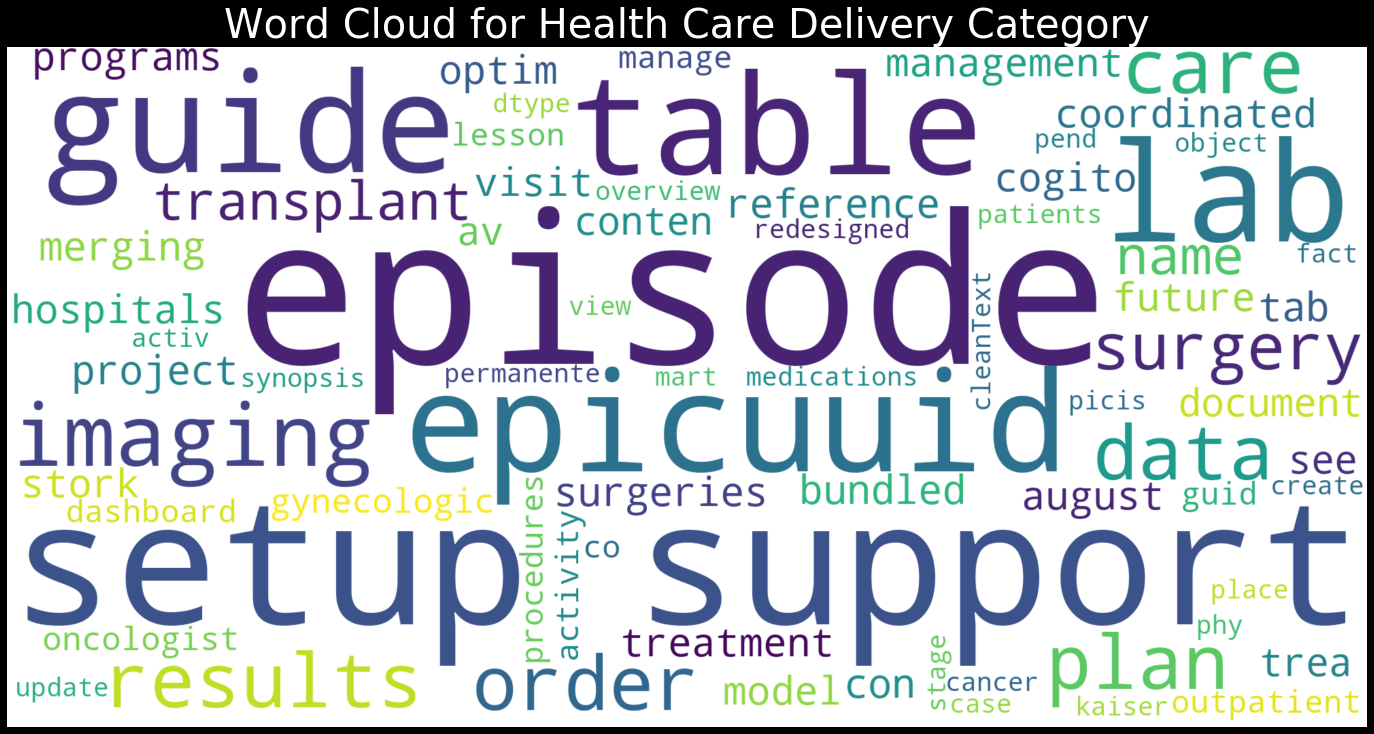

In [22]:
from wordcloud import WordCloud
#import matplotlib.pyplot as plt
text = df1[df1['Label']=='HealthCareDelivery']['cleanText']
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'white').generate(str(text))
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Word Cloud for Health Care Delivery Category',fontsize=40,color="white")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

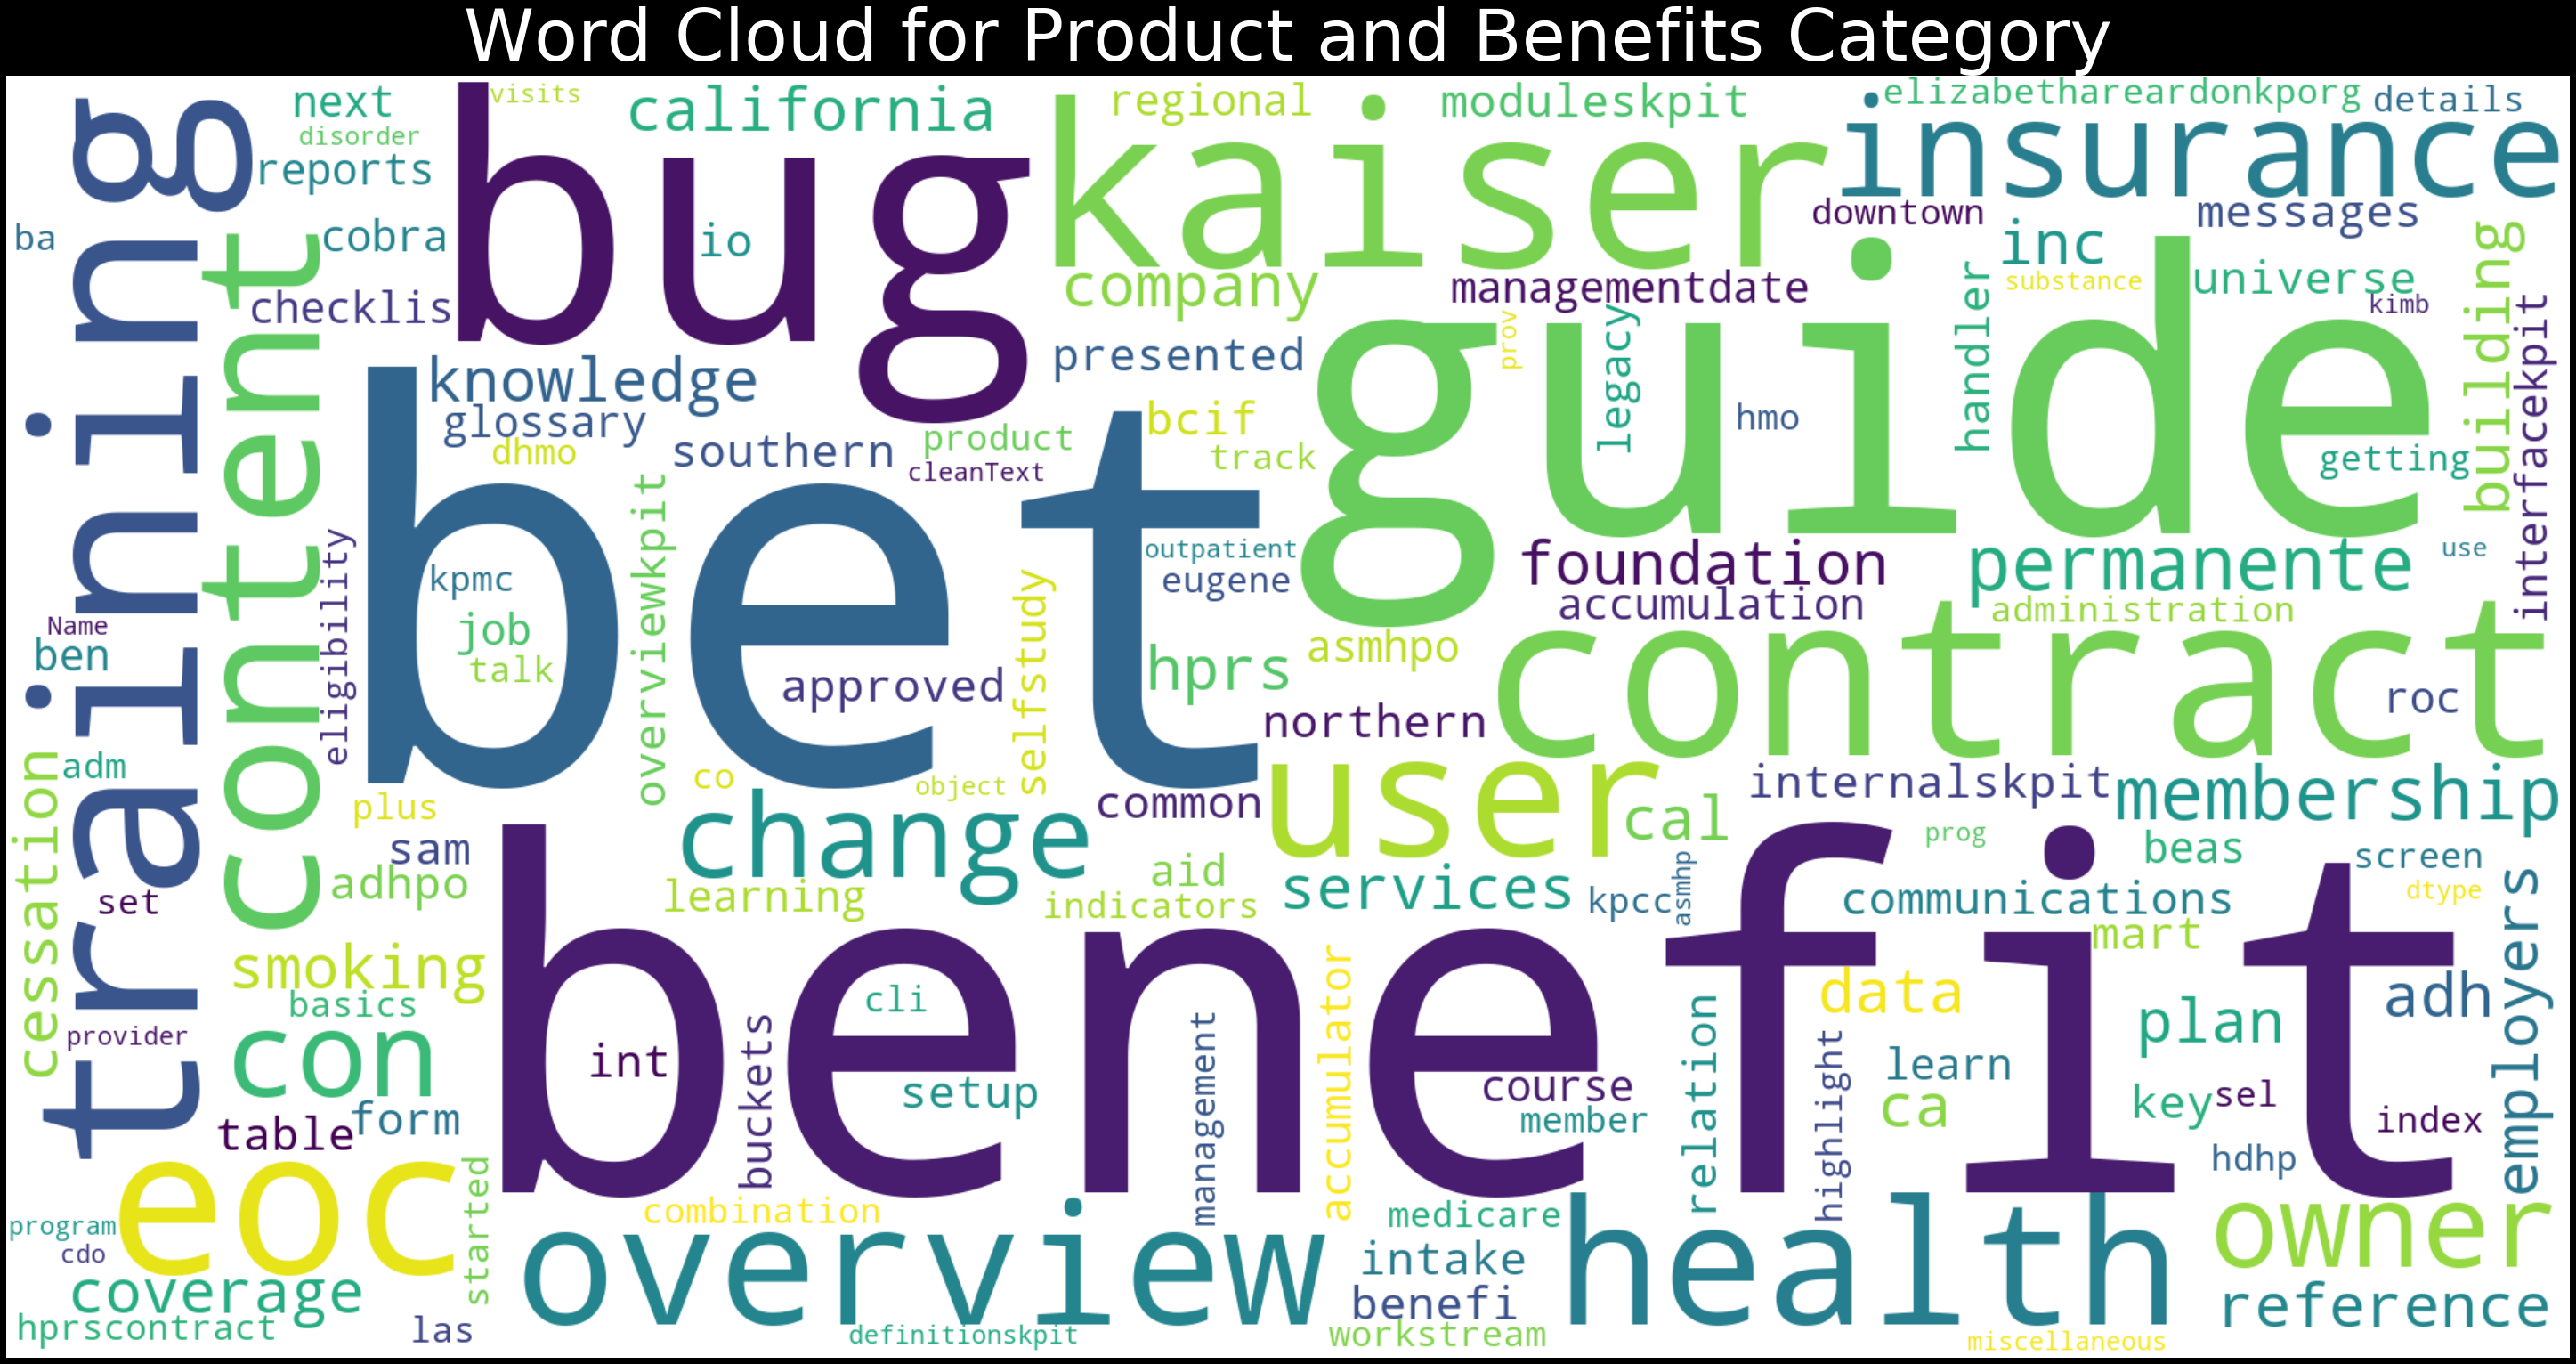

In [23]:
from wordcloud import WordCloud
#import matplotlib.pyplot as plt
text = df1[df1['Label']=='ProductandBenefits']['cleanText']
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'white').generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Word Cloud for Product and Benefits Category',fontsize=80,color="white")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

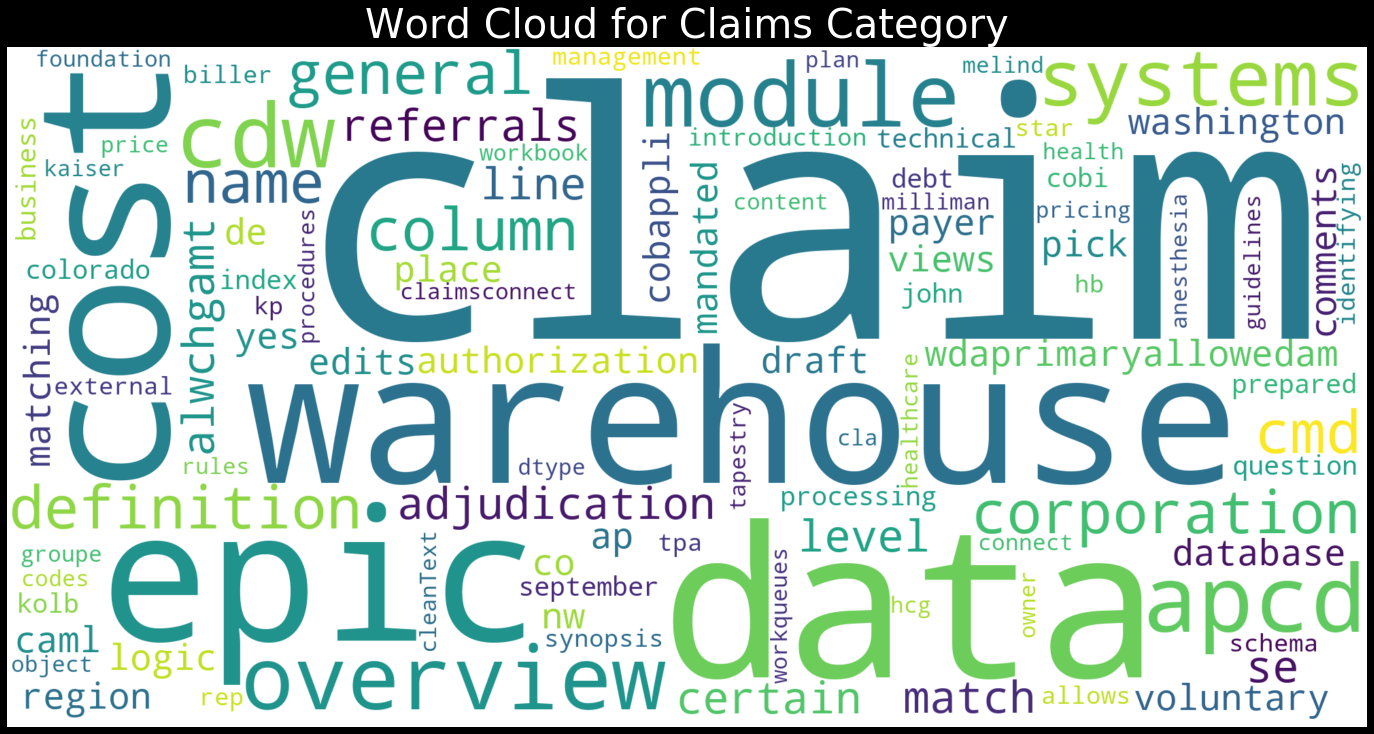

In [24]:
from wordcloud import WordCloud
#import matplotlib.pyplot as plt
text = df1[df1['Label']=='Claims']['cleanText']
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'white').generate(str(text))
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Word Cloud for Claims Category',fontsize=40,color="white")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

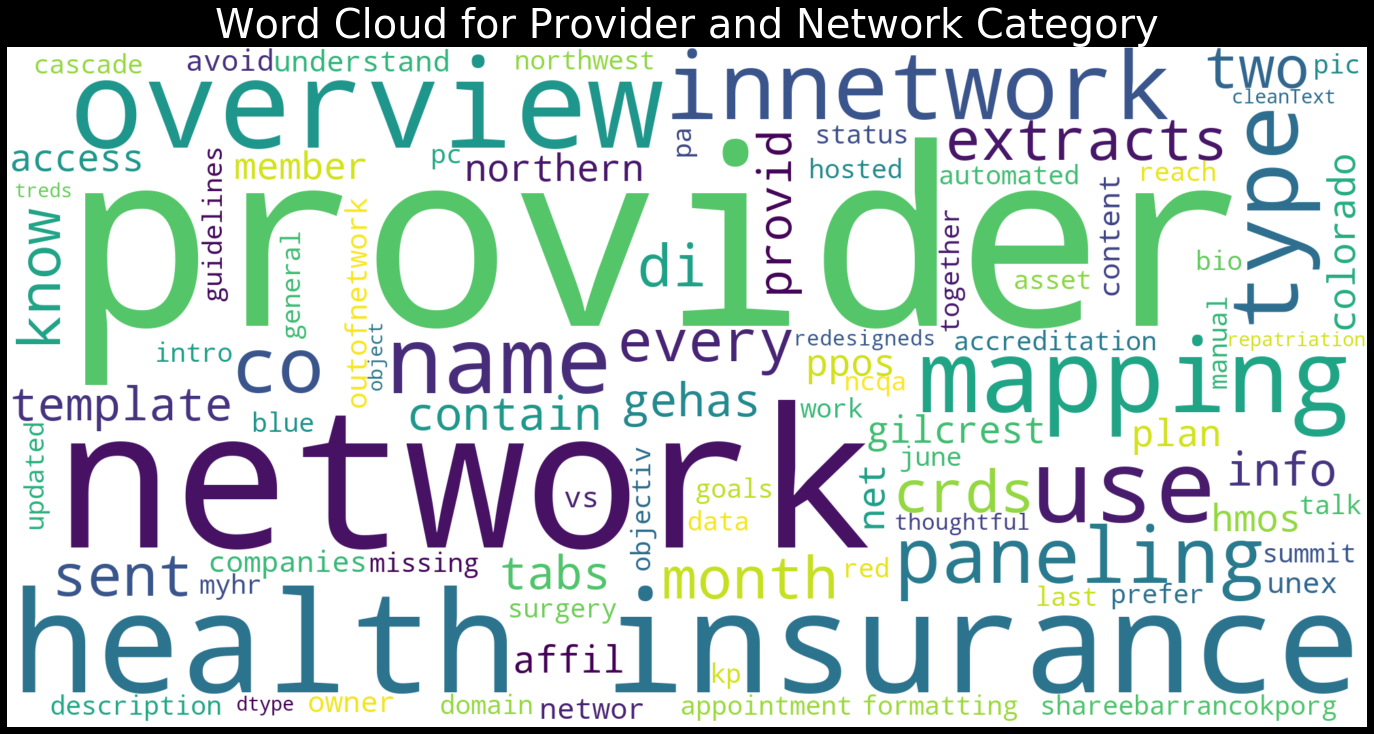

In [25]:

from wordcloud import WordCloud
#import matplotlib.pyplot as plt
text = df1[df1['Label']=='ProviderandNetwork']['cleanText']
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'white').generate(str(text))
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.title('Word Cloud for Provider and Network Category',fontsize=40,color="white")
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

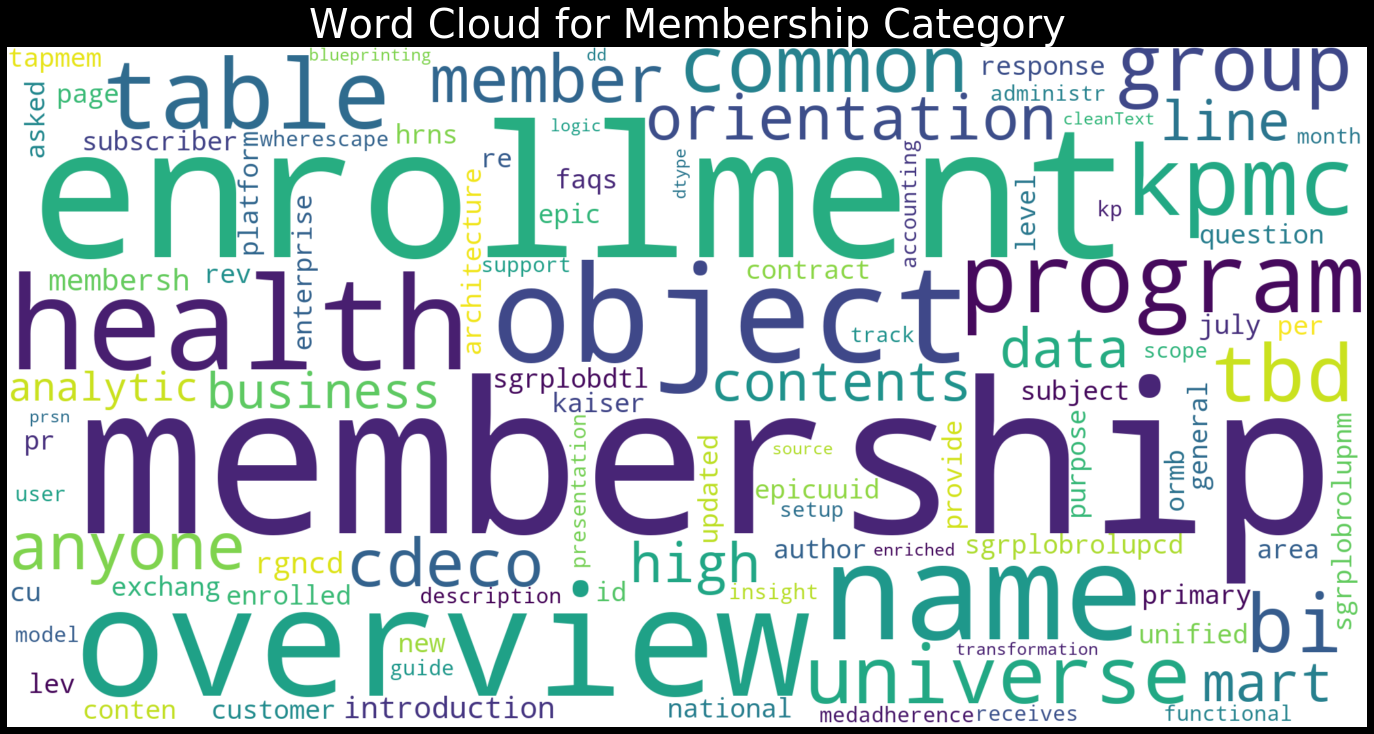

In [26]:

from wordcloud import WordCloud
#import matplotlib.pyplot as plt
text = df1[df1['Label']=='Membership']['cleanText']
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'white').generate(str(text))
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.title("Word Cloud for Membership Category",fontsize=40,color="white")
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Look at bi-grams
Reference: https://www.kaggle.com/bbose71/bbc-news-classification

In [27]:
# Use chi-square analysis to find corelation between features (importantce of words) and labels(news category) 
from sklearn.feature_selection import chi2

N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for Label, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
  indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
  feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
  print("# '{}':".format(Label))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'Claims':
  . Most correlated unigrams:
       . claim
       . claims
       . cdw
  . Most correlated bigrams:
       . claim level
       . professional claims
       . claim line
# 'HealthCareDelivery':
  . Most correlated unigrams:
       . optime
       . episodes
       . surgeries
  . Most correlated bigrams:
       . linked episode
       . guide epicuuid
       . patients chart
# 'Membership':
  . Most correlated unigrams:
       . kpmc
       . membershipconnect
       . person
  . Most correlated bigrams:
       . base component
       . line business
       . kp membershipconnect
# 'Pharmacy':
  . Most correlated unigrams:
       . dispensed
       . medication
       . pharmacy
  . Most correlated bigrams:
       . clinic administered
       . outpatient pharmacy
       . pharmacy data
# 'ProductandBenefits':
  . Most correlated unigrams:
       . benefits
       . regional
       . bets
  . Most correlated bigrams:
       . substance use
       . group agreement
      

In [28]:
# Apply stemming and check again

from nltk.stem import SnowballStemmer
stemmer=SnowballStemmer('english')
#df1['stemmedcleanText']=df1['cleanText'].apply(lambda x:[stemmer.stem(y) for y in x])

In [29]:
from nltk.tokenize import WhitespaceTokenizer
w_tokenizer= WhitespaceTokenizer()
def stemmed_text(text):
    '''Apply Snowball stemming'''
    
    text= [stemmer.stem(w) for w in w_tokenizer.tokenize(str(text))]
    return " ".join(text)
    
df1['stemmedcleanText'] = pd.DataFrame(df1.cleanText.apply(lambda x: stemmed_text(x)))

In [30]:
df1['stemmedcleanText'].head()

0    adjud match referr claim certain servic might ...
1    alwchgamt claim line level wdaprimaryallowedam...
2    region nw mandat apcd place yes voluntari apcd...
3    apcd payer claim databas overview washington s...
4    claim data warehous cdw modul pick view decemb...
Name: stemmedcleanText, dtype: object

In [31]:
#from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=6, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df1.stemmedcleanText).toarray() # Remaps the words in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents
 

In [32]:
# Use chi-square analysis to find corelation between features (importantce of words) and labels(news category) 
#from sklearn.feature_selection import chi2

#N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for Label, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
  indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
  feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
  print("# '{}':".format(Label))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'Claims':
  . Most correlated unigrams:
       . paid
       . claim
       . cdw
  . Most correlated bigrams:
       . claim line
       . paid claim
       . profession claim
# 'HealthCareDelivery':
  . Most correlated unigrams:
       . clinician
       . finish
       . episod
  . Most correlated bigrams:
       . episod episod
       . guid epicuuid
       . episod creat
# 'Membership':
  . Most correlated unigrams:
       . membership
       . kpmc
       . membershipconnect
  . Most correlated bigrams:
       . base compon
       . line busi
       . kp membershipconnect
# 'Pharmacy':
  . Most correlated unigrams:
       . pharmacist
       . pharmaci
       . dispens
  . Most correlated bigrams:
       . administ medic
       . outpati pharmaci
       . pharmaci data
# 'ProductandBenefits':
  . Most correlated unigrams:
       . eoc
       . benefit
       . bet
  . Most correlated bigrams:
       . group agreement
       . intern use
       . benefit contract
# 'ProviderandN

In [33]:
# Apply stemming with Porter Stemmer and check again

from nltk.stem import PorterStemmer
stemmer=PorterStemmer()
df1['stemmedcleanText'] = pd.DataFrame(df1.cleanText.apply(lambda x: stemmed_text(x)))

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=6, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df1.stemmedcleanText).toarray() # Remaps the words in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents
#N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for Label, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
  indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
  feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
  print("# '{}':".format(Label))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'Claims':
  . Most correlated unigrams:
       . paid
       . claim
       . cdw
  . Most correlated bigrams:
       . claim line
       . paid claim
       . profession claim
# 'HealthCareDelivery':
  . Most correlated unigrams:
       . clinician
       . finish
       . episod
  . Most correlated bigrams:
       . episod episod
       . guid epicuuid
       . episod creat
# 'Membership':
  . Most correlated unigrams:
       . membership
       . kpmc
       . membershipconnect
  . Most correlated bigrams:
       . base compon
       . line busi
       . kp membershipconnect
# 'Pharmacy':
  . Most correlated unigrams:
       . pharmacist
       . pharmaci
       . dispens
  . Most correlated bigrams:
       . administ medic
       . outpati pharmaci
       . pharmaci data
# 'ProductandBenefits':
  . Most correlated unigrams:
       . eoc
       . benefit
       . bet
  . Most correlated bigrams:
       . group agreement
       . intern use
       . benefit contract
# 'ProviderandN

In [83]:
# Apply lematization and check again

from textblob import Word

df1['LemmatizedcleanText'] = pd.DataFrame(df1.cleanText.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])))
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=6, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df1.LemmatizedcleanText).toarray() # Remaps the words in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents
N = 3  # We are going to look for top 4 categories

#For each category, find words that are highly corelated to it
for Label, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
  indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
  feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
  print("# '{}':".format(Label))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'Claims':
  . Most correlated unigrams:
       . institutional
       . claim
       . cdw
  . Most correlated bigrams:
       . claim line
       . paid claim
       . professional claim
# 'HealthCareDelivery':
  . Most correlated unigrams:
       . finished
       . episode
       . optime
  . Most correlated bigrams:
       . linked episode
       . guide epicuuid
       . episode episode
# 'Membership':
  . Most correlated unigrams:
       . membership
       . kpmc
       . membershipconnect
  . Most correlated bigrams:
       . base component
       . line business
       . kp membershipconnect
# 'Pharmacy':
  . Most correlated unigrams:
       . pharmacist
       . pharmacy
       . medication
  . Most correlated bigrams:
       . clinic administered
       . outpatient pharmacy
       . pharmacy data
# 'ProductandBenefits':
  . Most correlated unigrams:
       . benefit
       . regional
       . bet
  . Most correlated bigrams:
       . group agreement
       . internal use
